In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

from net_flow_opt.utils import components, structure, activities_duration
from net_flow_opt.system import System
from net_flow_opt.scheduler import  Plan, Activity
from net_flow_opt.continuous_model import ContinuousModel
from net_flow_opt.callbacks import TrackPerformance


Main parameters of the experiment are declared here.

In [2]:
pop_size = 150
termination = ('n_gen', 250)
seed = 1124
eps = 1e-3

The cells below repeat the experiment with a different number of resources.

In [3]:
def experiment(resources):
    system = System(structure, resources, components)

    dates = np.array([c.x_star for c in components])

    original_activities = [
        Activity(component, date, duration)
        for component, date, duration in zip(system.components, dates, activities_duration)
    ]

    original_plan = Plan(
        system=system,
        activities=original_activities
    )

    problem = ContinuousModel(
        system=system,
        resources=resources,
        activities_duration=activities_duration
    )

    T = 200

    d_t = np.vstack([- dates, T - dates])

    i = np.argmax(np.abs(d_t), axis=0)

    d_t = d_t[i, np.arange(d_t.shape[1])]

    ref_point = np.array([
        system.regular_flow * T,
        np.sum([a.h(d_t[i] + eps) for i, a in enumerate(original_activities)])
    ])

    algorithm = NSGA2(
        pop_size=pop_size,
        eliminate_duplicates=True,
        callback=TrackPerformance(ref_point=ref_point)
    )

    res = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=termination,
        seed=seed,
        save_history=True,
    )

    return res

In [4]:
for resources in range(3, 6):
    res = experiment(resources)

    # save data
    df = pd.DataFrame(res.opt.get("F"), columns=['IC', 'LF'])
    df.to_csv(f'../data/continuous_r{resources}.csv', index=False)

    df = pd.DataFrame(np.array(res.algorithm.callback.data['hv']), columns=['HV'])
    df.index.name = 'iter'
    df.to_csv(f'../data/continuous_hv_r{resources}.csv')

    with open(f'../data/continuous_r{resources}', 'wb') as f:
        dill.dump(res, f)

    print(f"Experiment with r={resources} completed.")

Experiment with r=3 completed.
Experiment with r=4 completed.
Experiment with r=5 completed.


Run the experiment using the number of iterations to stop the algorithm.

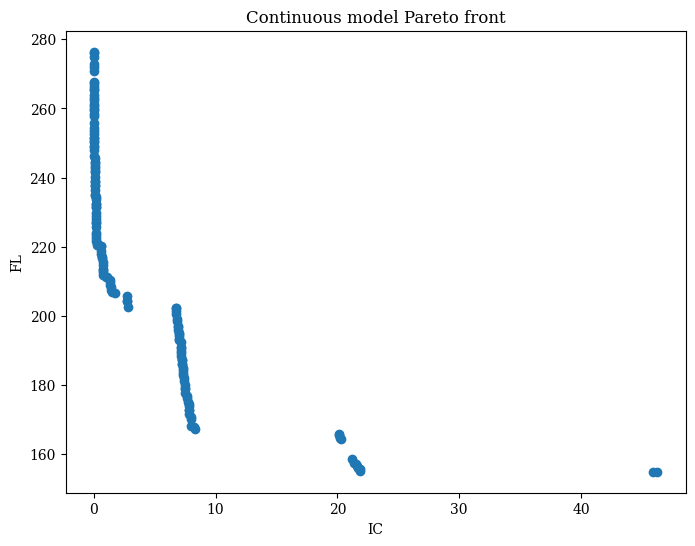

In [5]:
F = res.opt.get("F")
plot = Scatter(
    title="Continuous model Pareto front",
    labels=['IC', 'FL']
)
plot.add(F)
plot.show()

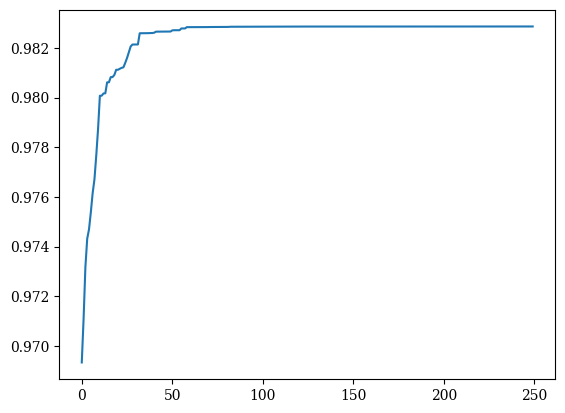

In [6]:
hv = np.array(res.algorithm.callback.data['hv'])

plt.plot(hv)